Image Processing For TOEIC-OMR-Grading

In [141]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Size: 1545 x 2000


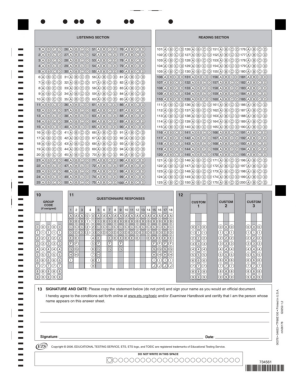

In [142]:
img_path = 'sample2.png' 

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if img is None:
    print("Không load được ảnh! Kiểm tra tên file và đường dẫn.")
else:
    print(f"Size: {img.shape[1]} x {img.shape[0]}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

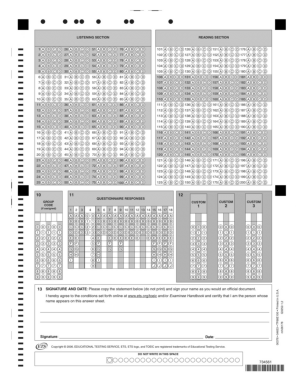

In [143]:
if img is None:
    print("Không load được ảnh!")
else:
    # Chuyển sang grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Hiển thị ảnh grayscale
    plt.imshow(img_gray, cmap='gray')
    plt.axis('off')
    plt.show()

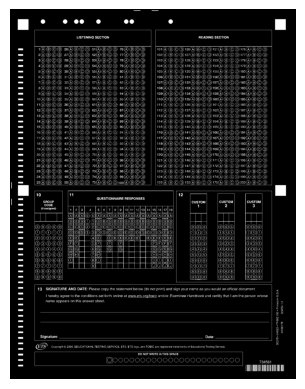

In [144]:
if img_gray is None:
    print("Chưa có ảnh grayscale! Chạy cell grayscale trước.")
else:
    # Thresholding: pixel > 127 → 255, <=127 → 0
    _, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Hiển thị ảnh binary
    plt.imshow(img_binary, cmap='gray')
    plt.axis('off')
    plt.show()


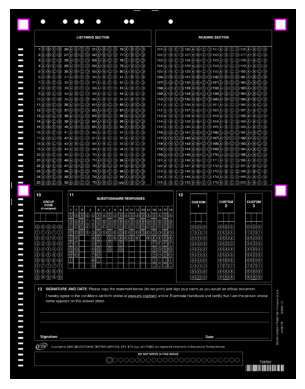

In [145]:
if img_binary is None:
    print("Chưa có ảnh binary!")
else:
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    markers = []
    min_size = 36
    min_density = 0.7  # tối thiểu 70% pixel trắng trong bounding box
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < min_size or h < min_size:
            continue
        aspect_ratio = w / h
        if not (0.8 <= aspect_ratio <= 1.2):
            continue 
        # Tính density (tỉ lệ pixel trắng)
        roi = img_binary[y:y+h, x:x+w]
        density = np.sum(roi==255) / (w*h)
        if density >= min_density:
            markers.append((x, y, w, h))
    img_display = cv2.cvtColor(img_binary.copy(), cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in markers:
        cv2.rectangle(img_display, (x, y), (x+w, y+h), (255,0,255), 5)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

x_min = 42	y_min = 55
x_max = 1432	y_max = 952


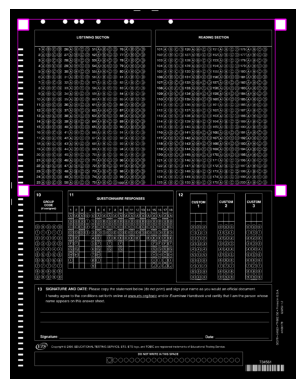

In [146]:
centers = np.array([[x + w//2, y + h//2] for x, y, w, h in markers])
s = centers.sum(axis=1)
diff = np.diff(centers, axis=1)

tl_idx = np.argmin(s)
br_idx = np.argmax(s)
tr_idx = np.argmin(diff)
bl_idx = np.argmax(diff)

# Lấy các điểm pixel theo yêu cầu
tl_rect = markers[tl_idx]
tr_rect = markers[tr_idx]
br_rect = markers[br_idx]
bl_rect = markers[bl_idx]

# Crop bằng slicing numpy
x_min = tl_rect[0]     
y_min = tl_rect[1]    

x_max = tr_rect[0]
y_max = bl_rect[1]    

print(f"x_min = {x_min}\ty_min = {y_min}\nx_max = {x_max}\ty_max = {y_max}")        

img_framed = img_binary.copy() 
    
cv2.rectangle(img_display, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 255), 2)       

# Hiển thị khung
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Cropped size: 1390 x 897 (WxH)


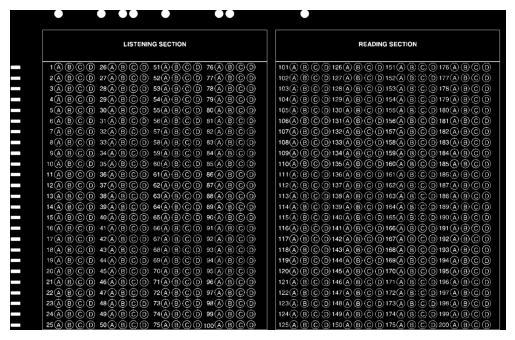

In [147]:
# Che phủ marker tl bằng hình chữ nhật ĐẶC màu đen (giá trị 0)
x_tl, y_tl, w_tl, h_tl = tl_rect
cv2.rectangle(img_binary, (int(x_tl), int(y_tl)), (int(x_tl + w_tl), int(y_tl + h_tl)), 0, -1)

img_crop = img_binary[y_min:y_max, x_min:x_max]
print(f"Cropped size: {img_crop.shape[1]} x {img_crop.shape[0]} (WxH)")

plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Found: 25 dashes and 8 bubbles.


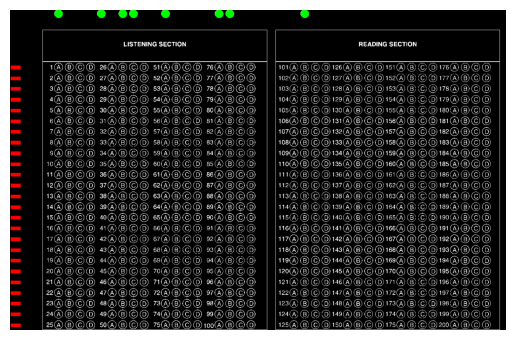

In [148]:
# Tìm lại contours, nhưng với kích thước nhỏ hơn
contours, _ = cv2.findContours(img_crop.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

dash_markers = [] # 25 dashes bên trái
bubble_markers = [] # 8 bubbles bên trên
min_dash_size = 10

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    if w < min_dash_size:
        continue

    aspect_ratio = w / h
    
    # Lọc Dash (Thường là thanh ngang, nằm dọc biên trái, x nhỏ)
    if aspect_ratio > 2: # Dash thường rất dài và mỏng (w/h lớn)
        # Chỉ lấy các dash nằm gần biên trái (ví dụ: x < 100)
        if x < 50: 
            dash_markers.append((x, y, w, h))

    # Lọc Bubble (Thường là ô vuông/tròn nhỏ hơn, nằm dọc biên trên, y nhỏ)
    elif 0.5 <= aspect_ratio <= 2.0: # Hình vuông/chữ nhật nhỏ
        # Chỉ lấy các bubble nằm gần biên trên (ví dụ: y < 100)
        if y < 50:
            bubble_markers.append((x, y, w, h))

# Sắp xếp và chọn 25 dash và 8 bubble (Nếu tìm được nhiều hơn)
# Dash cần sắp xếp theo trục Y (từ trên xuống)
dash_markers.sort(key=lambda item: item[1]) # Sắp xếp theo y
dash_markers = dash_markers[:25] # Chỉ lấy 25 cái đầu tiên

# Bubble cần sắp xếp theo trục X (từ trái sang)
bubble_markers.sort(key=lambda item: item[0]) # Sắp xếp theo x
bubble_markers = bubble_markers[:8] # Chỉ lấy 8 cái đầu tiên

img_crop = cv2.cvtColor(img_crop.copy(), cv2.COLOR_GRAY2BGR)

for x, y, w, h in dash_markers:
    cv2.rectangle(img_crop, (x, y), (x + w, y + h), (0, 0, 255), -1)

for x, y, w, h in bubble_markers:
    cv2.circle(img_crop, (int(x+w//2), int(y+h//2)), int(max(w, h) // 2), (0, 255, 0), -1)

print(f"Found: {len(dash_markers)} dashes and {len(bubble_markers)} bubbles.")
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

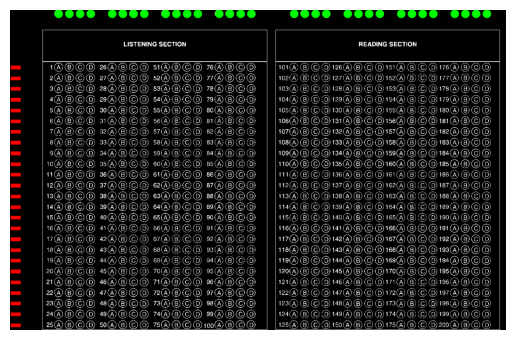

In [149]:
# Tọa độ X của các cột mốc đã biết (dùng tâm X)
known_x_coords = np.array([x + w // 2 for x, y, w, h in bubble_markers])

# Dữ liệu Bounding Box của bubble để tính bán kính (lấy từ bubble 1)
_, _, w_b, h_b = bubble_markers[0]
radius = int(max(w_b, h_b) // 2)

X = known_x_coords

U_6_7 = X[3] - X[2]
U_13_14 = X[6] - X[5]
U = (U_6_7 + U_13_14) / 2.0
L_C_1_9 = X[4] - X[0]
L_C_9_13 = X[5] - X[4]
L_C = (L_C_1_9 / 2.0 + L_C_9_13) / 2.0

inferred_x_coords = np.zeros(32) 

# Xác định vị trí các cột mốc đã biết
# Bằng phép cộng/trừ U và L_C từ các điểm đã biết

inferred_x_coords[0:4] = [X[0] + i * U for i in range(4)]
inferred_x_coords[4:8] = [X[0] + L_C + i * U for i in range(4)]
inferred_x_coords[8:12] = [X[0] + 2*L_C + i * U for i in range(4)]
inferred_x_coords[12:16] = [X[0] + 3*L_C + i * U for i in range(4)]

inferred_x_coords[16:20] = [X[7] + (i-1) * U for i in range(4)]
inferred_x_coords[20:24] = [X[7] + L_C + (i-1) * U for i in range(4)]
inferred_x_coords[24:28] = [X[7] + 2*L_C + (i-1) * U for i in range(4)]
inferred_x_coords[28:32] = [X[7] + 3*L_C + (i-1) * U for i in range(4)]

final_x = np.round(inferred_x_coords).astype(int)

x_gap, y_gap, w_gap, h_gap = bubble_markers[1]
cv2.rectangle(img_crop, (int(x_gap), int(y_gap)), (int(x_gap + w_gap), int(y_gap + h_gap)), 0, -1)

avg_y = np.mean([y + h // 2 for x, y, w, h in bubble_markers]).astype(int)

# Vẽ 16 bubble nội suy lên ảnh màu (img_crop_color)
for x_final in final_x:
    center = (x_final, avg_y)
    cv2.circle(img_crop, center, radius, (0, 255, 0), -1) 
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

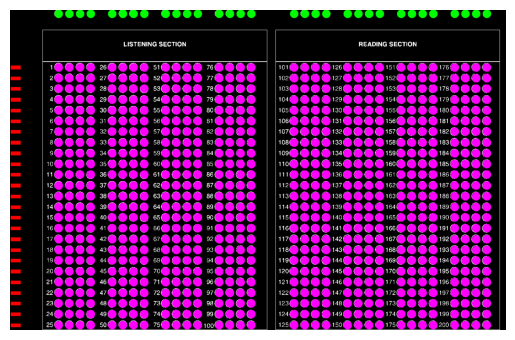

In [150]:
# Tính Tọa độ Y trung tâm của 25 Dash Markers
center_y_coords = np.array([y + h // 2 for x, y, w, h in dash_markers])

y_diffs = np.diff(center_y_coords) # np.diff tính delta giữa các phần tử
U_Y = np.mean(y_diffs)

final_y = np.round(center_y_coords).astype(int)

# 1. Mở rộng Tọa độ X: Lặp lại mỗi X 25 lần (cho 25 hàng)
X_coords_expanded = np.repeat(final_x, len(final_y)) # 32 * 25 = 800

# 2. Mở rộng Tọa độ Y: Lặp lại 32 lần (theo cột)
Y_coords_expanded = np.tile(final_y, len(final_x)) # 25 * 32 = 800

# 3. Gom lại thành danh sách 800 tọa độ (X, Y)
all_bubble_locations = list(zip(X_coords_expanded, Y_coords_expanded))

# 3. VẼ LƯỚI 800 BUBBLE (Tô đặc, Kích cỡ radius)
pink_color = (255, 0, 255) # Màu Hồng (Magenta)
thickness = -1 # Tô đặc
# Bán kính (radius) đã được xác định từ kích cỡ bubble ban đầu, đảm bảo kích thước đúng.

for x_final, y_final in all_bubble_locations:
    center = (x_final, y_final)
    # Kích cỡ (radius) được sử dụng để vẽ, đảm bảo kích thước bằng bubble marker ban đầu.
    cv2.circle(img_crop, center, radius, pink_color, thickness) 

# HIỂN THỊ KẾT QUẢ
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()